Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.tree import DecisionTreeClassifier

In [21]:
def cleanup(df):
  #columns assesed by human annalisis of a sample to be duplicates
  df = df.drop(['recorded_by','extraction_type_group','extraction_type_class','quantity_group','waterpoint_type_group','source_type'],axis=1)
  #making sure no nan's were acidentaly left in longitude or latitude columns as 0's
  df['longitude']=df['longitude'].replace({0:np.NaN, -2.000000e-08:np.NaN})
  df['latitude']=df['latitude'].replace({0:np.NaN, -2.000000e-08:np.NaN})
  #drops columns with a lot of nan values greater than half
  bad_cols = [col for col in df.columns
           if df[col].count() < .5]
  df.drop(columns=bad_cols, inplace=True)
  #drops columns with high cordinality
  high = [col for col in df.select_dtypes('object').columns
                    if df[col].nunique() > 100]
  df.drop(columns=high, inplace=True)
  return df

In [22]:


# Merge train_features.csv & train_labels.csv
train = cleanup(pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id'))

# Read test_features.csv & sample_submission.csv
test = cleanup(pd.read_csv(DATA_PATH+'waterpumps/test_features.csv').set_index('id'))
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [23]:
target = 'status_group'
y_train = train[target]
X_train = train.drop(columns=target)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   gps_height         59400 non-null  int64  
 2   longitude          57588 non-null  float64
 3   latitude           57588 non-null  float64
 4   num_private        59400 non-null  int64  
 5   basin              59400 non-null  object 
 6   region             59400 non-null  object 
 7   region_code        59400 non-null  int64  
 8   district_code      59400 non-null  int64  
 9   population         59400 non-null  int64  
 10  public_meeting     56066 non-null  object 
 11  scheme_management  55523 non-null  object 
 12  permit             56344 non-null  object 
 13  construction_year  59400 non-null  int64  
 14  extraction_type    59400 non-null  object 
 15  management         59400 non-null  object 
 16  management_group  

In [9]:
bag_tree = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    BaggingClassifier(DecisionTreeClassifier(),
                      max_samples=.5,
                      random_state=42,
                      n_jobs=-1,
                      bootstrap=False,
                      bootstrap_features= False)
)
params = {
    'baggingclassifier__n_estimators': range(500,1001,10),
}

baggrid = GridSearchCV(
    bag_tree,
    param_grid = params,
    cv=10,
    n_jobs=-1,
    verbose=10
)

In [10]:
baggrid.fit(X_train,y_train)

Fitting 10 folds for each of 51 candidates, totalling 510 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 37.1min
C:\Users\Antony\anaconda3\lib\site-packages\joblib\exte

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('baggingclassifier',
                                        BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                                          bootstrap=False,
                                                          max_samples=0.5,
                                                          n_jobs=-1,
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'baggingclassifier__n_estimators': range(500, 1001, 10)},
             verbose=10)

In [11]:
print(baggrid.best_score_)
print(baggrid.best_estimator_)
print(baggrid.best_params_)

0.8099999999999999
Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_class', 'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake Nyasa                 1
Lake...
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe             1
communal standpipe multiple    2
hand pump                      3
other 

In [12]:
# Train-val split to apply the predictor to and create the confusion matrix
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

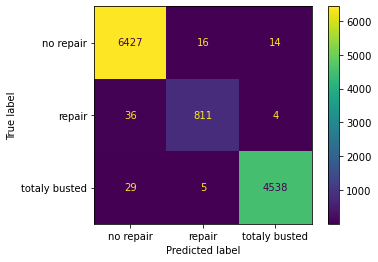

In [14]:
#plot the confusion matrix for the bagged clasifier
plot_confusion_matrix(baggrid,X_val,y_val,values_format='.0f',
                      display_labels=['no repair','repair','totaly busted'])
plt.show()

In [15]:
print(classification_report(y_val,baggrid.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.99      1.00      0.99      6457
functional needs repair       0.97      0.95      0.96       851
         non functional       1.00      0.99      0.99      4572

               accuracy                           0.99     11880
              macro avg       0.99      0.98      0.98     11880
           weighted avg       0.99      0.99      0.99     11880



In [16]:
bag_tree2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    BaggingClassifier(DecisionTreeClassifier(),
                      max_samples=.5,
                      random_state=42,
                      n_jobs=-1,
                      bootstrap=False,
                      bootstrap_features= False)
)
params = {
    'baggingclassifier__n_estimators': range(50,501,10),
}

baggrid2 = GridSearchCV(
    bag_tree2,
    param_grid = params,
    cv=10,
    n_jobs=-1,
    verbose=10
)

In [17]:
baggrid2.fit(X_train,y_train)

Fitting 10 folds for each of 46 candidates, totalling 460 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 1

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('baggingclassifier',
                                        BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                                          bootstrap=False,
                                                          max_samples=0.5,
                                                          n_jobs=-1,
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'baggingclassifier__n_estimators': range(50, 501, 10)},
             verbose=10)

In [19]:
print(baggrid2.best_score_)
print(baggrid2.best_estimator_)
print(baggrid2.best_params_)

0.81010101010101
Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_class', 'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake Nyasa                 1
Lake...
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe             1
communal standpipe multiple    2
hand pump                      3
other   

In [25]:
def cleanup2(df):
  #columns assesed by human annalisis of a sample to be duplicates
  df = df.drop(['recorded_by','extraction_type_group','quantity'],axis=1)
  #making sure no nan's were acidentaly left in longitude or latitude columns as 0's
  df['longitude']=df['longitude'].replace({0:np.NaN, -2.000000e-08:np.NaN})
  df['latitude']=df['latitude'].replace({0:np.NaN, -2.000000e-08:np.NaN})
  #drops columns with a lot of nan values greater than half
  bad_cols = [col for col in df.columns
           if df[col].count() < .5]
  df.drop(columns=bad_cols, inplace=True)
  #drops columns with high cordinality
  high = [col for col in df.select_dtypes('object').columns
                    if df[col].nunique() > 100]
  df.drop(columns=high, inplace=True)
  return df

# Merge train_features.csv & train_labels.csv
train5 = cleanup2(pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id'))


In [41]:

# Read test_features.csv & sample_submission.csv
test5 = cleanup2(pd.read_csv(DATA_PATH+'waterpumps/test_features.csv').set_index('id'))

In [26]:
y_train5 = train5[target]
X_train5 = train5.drop(columns=target)

In [34]:
forest_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(max_samples=.5,
                           random_state=42,
                           n_jobs=-1)
)
params = {
    'randomforestclassifier__n_estimators': range(50,1001,10),
    'randomforestclassifier__max_depth': range(15,36,5)
}

grid5 = GridSearchCV(
    forest_model,
    param_grid = params,
    cv=10,
    n_jobs=-1,
    verbose=10
)

In [35]:
grid5.fit(X_train5,y_train5)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_samples=0.5,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(15, 36, 5),
                         'randomforestclassifier__n_estimators': range(50, 1001, 10)},
             verbose=10)

In [36]:
print(grid5.best_score_)
print(grid5.best_estimator_)
print(grid5.best_params_)

0.8147811447811447
Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity_group',
                                      'source', 'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group'],
                                map...
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_gro

In [42]:
X_test5 = test5
pre = grid5.predict(X_test5)
submission = pd.DataFrame(pre,columns=['status_group'],index=X_test5.index)
submission['id']=submission.index
submission= submission[['id','status_group']]
submission.reset_index(drop=True,inplace=True)
submission.to_csv('grided_forest_x.csv',index=False)

In [44]:
X_test = test
pre = baggrid2.predict(X_test)
submission2 = pd.DataFrame(pre,columns=['status_group'],index=X_test.index)
submission2['id']=submission2.index
submission2= submission2[['id','status_group']]
submission2.reset_index(drop=True,inplace=True)
submission2.to_csv('bag_forest_x.csv',index=False)

In [45]:
submission2.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
